# TP02 - Classificação de Fake News com TF-IDF e KNN

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Carregamento dos Dados

In [2]:
fake_df = pd.read_csv('Fake.csv', names=['title', 'text', 'subject', 'date'])
true_df = pd.read_csv('True.csv', names=['title', 'text', 'subject', 'date'])

fake_df['label'] = 0
true_df['label'] = 1

df = pd.concat([fake_df, true_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total de amostras: {len(df)}")
print(f"Notícias falsas: {len(fake_df)}")
print(f"Notícias verdadeiras: {len(true_df)}")
print(f"\nColunas: {df.columns.tolist()}")
print(f"\nPrimeira amostra de texto (100 chars): {df['text'].iloc[0][:100]}...")
df.head()

Total de amostras: 18898
Notícias falsas: 9481
Notícias verdadeiras: 9417

Colunas: ['title', 'text', 'subject', 'date', 'label']

Primeira amostra de texto (100 chars): WASHINGTON (Reuters) - New Jersey Governor Chris Christie, an early supporter of U.S. President-elec...


,title,text,subject,date,label
0,New Jersey's Christie mulls run to lead Republ...,WASHINGTON (Reuters) - New Jersey Governor Chr...,politicsNews,"December 1, 2016",1
1,Senators pledge aggressive Russia probe after ...,WASHINGTON (Reuters) - The leaders of the Sena...,politicsNews,"May 11, 2017",1
2,"[VIDEO] FAIRFAX, VA BOARD VOTES TO TEACH STUDE...","Fairfax, VA Public Schools are not unique in t...",left-news,"Jun 11, 2015",0
3,BOOM! SENATE PASSES Obamacare Repeal Resolutio...,The Senate is already rolling back President B...,left-news,"Jan 12, 2017",0
4,Puerto Rico oversight board appointed,WASHINGTON/NEW YORK (Reuters) - President Bara...,politicsNews,"August 31, 2016",1


## 1. Criação das Features com TF-IDF

Vamos usar TF-IDF para converter o texto em features numéricas. Isso mede a importância de cada palavra no documento.

In [3]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf_vectorizer.fit_transform(df['text'])
y = df['label']

print(f"Shape da matriz TF-IDF: {X.shape}")
print(f"Número de documentos: {X.shape[0]}")
print(f"Número de features (palavras): {X.shape[1]}")

Shape da matriz TF-IDF: (18898, 5000)
Número de documentos: 18898
Número de features (palavras): 5000


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")
print(f"Proporção de classes no treino: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Proporção de classes no teste: {y_test.value_counts(normalize=True).to_dict()}")

Tamanho do conjunto de treino: 15118
Tamanho do conjunto de teste: 3780
Proporção de classes no treino: {0: 0.5017198042069057, 1: 0.49828019579309435}
Proporção de classes no teste: {0: 0.5015873015873016, 1: 0.4984126984126984}


## 2. Modelagem com KNN - Explorando diferentes valores de K

Vamos testar diferentes valores de K e ver qual tem melhor acurácia.

In [5]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append({'k': k, 'accuracy': accuracy})
    print(f"K={k}: Acurácia = {accuracy:.4f}")

results_df = pd.DataFrame(results)
best_k = results_df.loc[results_df['accuracy'].idxmax(), 'k']
print(f"\nMelhor K: {int(best_k)} com acurácia: {results_df['accuracy'].max():.4f}")

K=1: Acurácia = 0.7399


K=3: Acurácia = 0.6767


K=5: Acurácia = 0.6513


K=7: Acurácia = 0.6286


K=9: Acurácia = 0.6135


K=11: Acurácia = 0.6034


K=13: Acurácia = 0.5952


K=15: Acurácia = 0.5860

Melhor K: 1 com acurácia: 0.7399


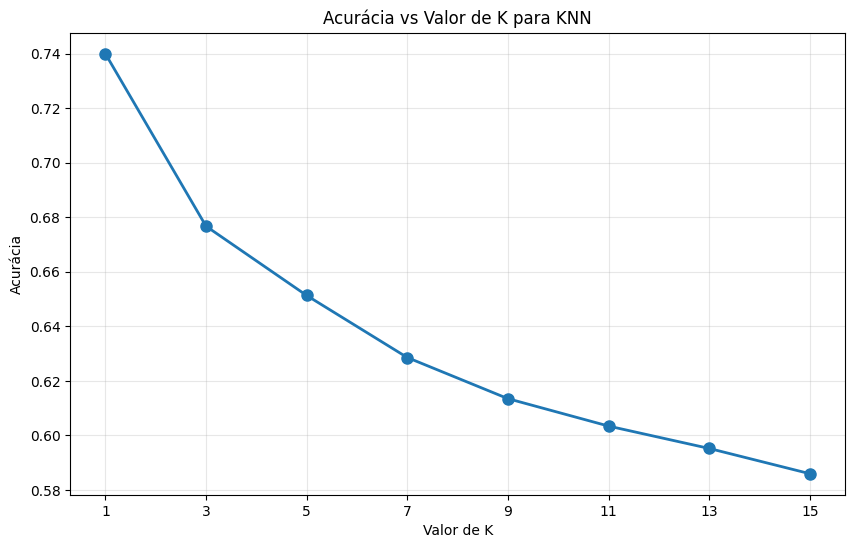

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['accuracy'], marker='o', linewidth=2, markersize=8)
plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
plt.title('Acurácia vs Valor de K para KNN')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.show()

## 3. Avaliação com Validação Cruzada

Usando validação cruzada para estimar melhor o desempenho do modelo.

In [7]:
best_k = int(best_k)
knn_best = KNeighborsClassifier(n_neighbors=best_k)

cv_scores = cross_val_score(knn_best, X_train, y_train, cv=5, scoring='accuracy')

print(f"Scores de validação cruzada (5-fold): {cv_scores}")
print(f"Média: {cv_scores.mean():.4f}")
print(f"Desvio padrão: {cv_scores.std():.4f}")

Scores de validação cruzada (5-fold): [0.70337302 0.72189153 0.71660053 0.71782997 0.71319881]
Média: 0.7146
Desvio padrão: 0.0063


## 4. Avaliação de Classificador Binário

Vamos treinar o modelo com o melhor K e avaliar com várias métricas.

In [8]:
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)
y_pred_proba = knn_best.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\nMétricas Detalhadas:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Sensibilidade (TPR): {sensitivity:.4f}")
print(f"Especificidade (TNR): {specificity:.4f}")

Classification Report:
              precision    recall  f1-score   support

        Fake       0.67      0.95      0.78      1896
        Real       0.91      0.53      0.67      1884

    accuracy                           0.74      3780
   macro avg       0.79      0.74      0.73      3780
weighted avg       0.79      0.74      0.73      3780


Métricas Detalhadas:
Acurácia: 0.7399
Precisão: 0.9077
Recall: 0.5324
F1-Score: 0.6711
Sensibilidade (TPR): 0.5324
Especificidade (TNR): 0.9462


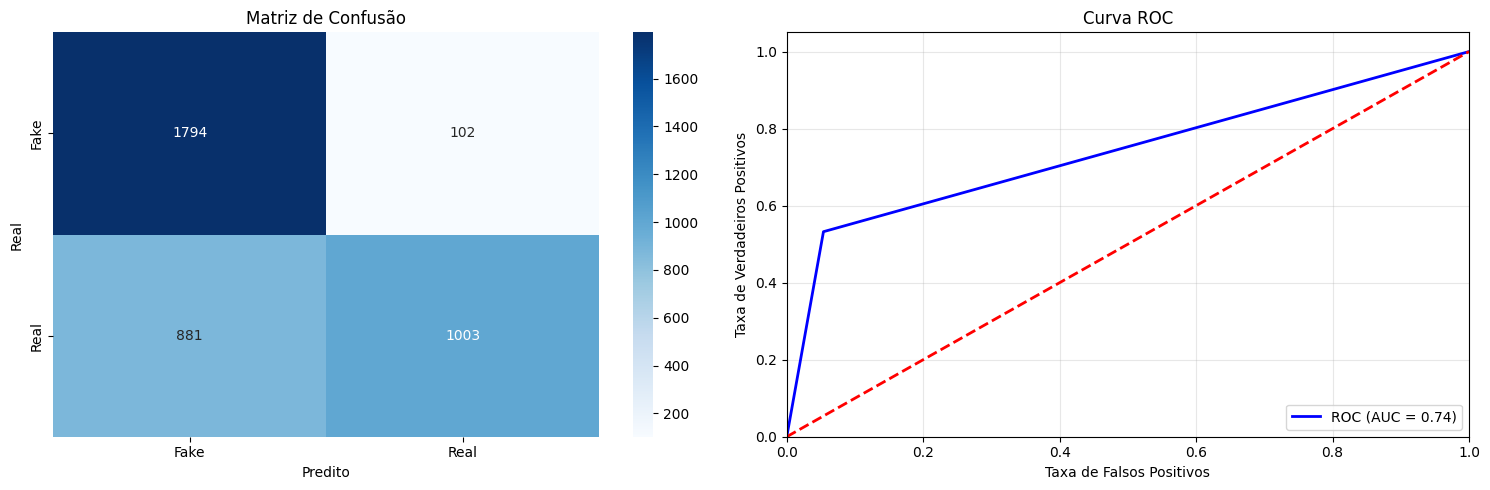


Área sob a curva ROC (AUC): 0.7393


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Real')
axes[0].set_title('Matriz de Confusão')
axes[0].set_xticklabels(['Fake', 'Real'])
axes[0].set_yticklabels(['Fake', 'Real'])

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Taxa de Falsos Positivos')
axes[1].set_ylabel('Taxa de Verdadeiros Positivos')
axes[1].set_title('Curva ROC')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nÁrea sob a curva ROC (AUC): {roc_auc:.4f}")

## 5. Interpretação dos Resultados

Analisando as métricas obtidas, o classificador KNN para fake news apresenta desempenho mediano com alguns problemas importantes:

### Problemas Identificados:
- **Acurácia de 74%**: Significa que o modelo erra 1 em cada 4 notícias
- **Recall baixo (53%)**: O modelo classifica incorretamente quase metade das notícias verdadeiras como falsas
- **Modelo desbalanceado**: Sensibilidade de 53% vs Especificidade de 95% indica forte viés para classificar como "fake"
- **K=1 indica overfitting**: O melhor desempenho com K=1 sugere que o modelo está memorizando os dados ao invés de generalizar

### Métricas Específicas:
- **AUC de 0.74**: Desempenho apenas razoável, longe do ideal (>0.85)
- **F1-Score**: A média harmônica mostra o impacto do baixo recall no desempenho geral
- **Alta especificidade (95%)**: O modelo é bom em identificar notícias falsas, mas péssimo com as verdadeiras

### Limitações Observadas:
- O modelo tem um viés conservador, preferindo classificar como fake quando em dúvida
- KNN com K=1 é problemático para produção pois é muito sensível a ruído
- Performance insuficiente para aplicação real onde erros podem ter consequências sérias

### Conclusão:
O classificador KNN com TF-IDF teve desempenho insatisfatório para o problema de fake news. Com apenas 74% de acurácia e recall de 53%, o modelo não é confiável para uso prático. Seria bom explorar outras técnicas como Random Forest, SVM ou redes neurais, além de trabalhar no balanceamento do dataset e feature engineering mais elaborado para obter resultados aceitáveis.